In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = None,
    mask = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


Checkpoint 100, Accuracy: 0.8765432098765432, Loss: 0.5823470221625434
Checkpoint 200, Accuracy: 0.8641975308641975, Loss: 0.5819164558693215


C:\Users\tcumi\github_repo\neural-network\python\layer.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.sum(w * X) + b


Checkpoint 300, Accuracy: 0.8580246913580247, Loss: 0.5942460519296152
Checkpoint 400, Accuracy: 0.8580246913580247, Loss: 0.5942460519296152
Checkpoint 500, Accuracy: 0.8580246913580247, Loss: 0.5942460519296152


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 0. 1.] <-> [[0.16596569]
 [0.44348896]
 [0.39054534]]
[0. 1. 0.] <-> [[0.4956864 ]
 [0.2518374 ]
 [0.25247613]]
[1. 0. 0.] <-> [[0.432896  ]
 [0.29586196]
 [0.27124205]]
[1. 0. 0.] <-> [[0.8994213 ]
 [0.08985095]
 [0.01072784]]
[1. 0. 0.] <-> [[0.8357185 ]
 [0.15146236]
 [0.0128191 ]]
[1. 0. 0.] <-> [[0.29901335]
 [0.38489044]
 [0.31609622]]
[1. 0. 0.] <-> [[0.889488  ]
 [0.10300583]
 [0.00750627]]
[1. 0. 0.] <-> [[0.46057996]
 [0.27292687]
 [0.26649317]]
[1. 0. 0.] <-> [[0.32355225]
 [0.3705498 ]
 [0.30589798]]
[0. 1. 0.] <-> [[0.73695695]
 [0.206447  ]
 [0.05659604]]
[0. 0. 1.] <-> [[0.03598505]
 [0.38247582]
 [0.58153915]]
[1. 0. 0.] <-> [[0.86559916]
 [0.12714823]
 [0.00725268]]
[0. 0. 1.] <-> [[0.02020884]
 [0.3285241 ]
 [0.651267  ]]
[1. 0. 0.] <-> [[0.906463  ]
 [0.07587206]
 [0.01766496]]
[1. 0. 0.] <-> [[0.50453734]
 [0.24930698]
 [0.24615565]]
[0. 1. 0.] <-> [[0.9013684 ]
 [0.05636782]
 [0.04226384]]
[0. 0. 1.] <-> [[0.01130155]
 [0.27181092]
 [0.71688753]]
[1. 0. 0.] <->

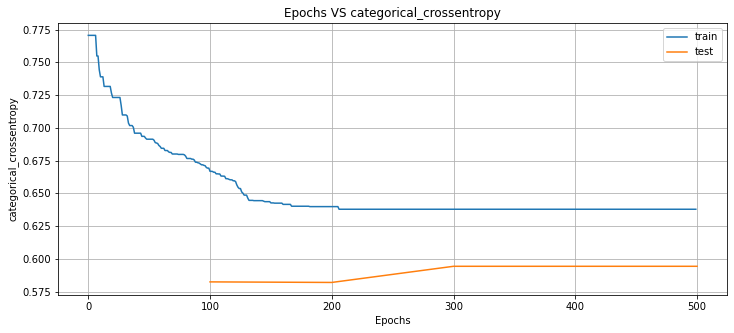

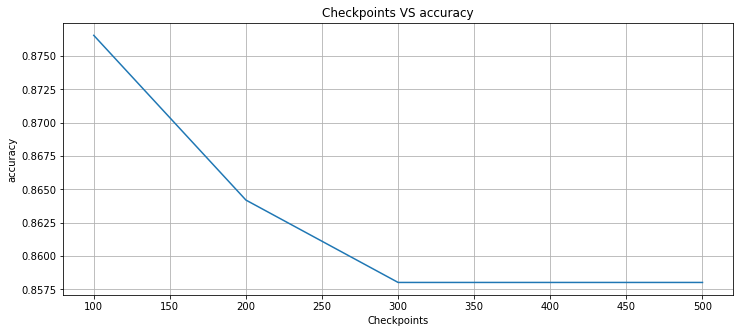

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8765432098765432, 'mean_square_error': 2.829386760770464, 'categorical_crossentropy': 0.5823470221625434, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 14, 'tn_hit': 14, 'fn_hit': 1}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}, 2: {'tp_hit': 9, 'fp_hit': 6, 'tn_hit': 89, 'fn_hit': 4}}, 'checkpoint': 100} 


{'accuracy': 0.8641975308641975, 'mean_square_error': 2.8961058489348, 'categorical_crossentropy': 0.5819164558693215, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 13, 'tn_hit': 15, 'fn_hit': 4}, 1: {'tp_hit': 3, 'fp_hit': 6, 'tn_hit': 87, 'fn_hit': 12}, 2: {'tp_hit': 7, 'fp_hit': 3, 'tn_hit': 92, 'fn_hit': 6}}, 'checkpoint': 200} 


{'accuracy': 0.8580246913580247, 'mean_square_error': 2.889594819811497, 'categorical_crossentropy': 0.5942460519296152, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 12, 'tn_hit': 16, 'fn_hit': 4}, 1: {'tp_hit': 2, 'fp_hit': 7, 'tn_hit': 86, 'fn_hit': 13}, 2: {'tp_hit': 7, 'fp_hit': 4, 'tn_hit': 91, 'fn_hit': 

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[[-1.7030708 ]
 [ 1.5262523 ]
 [ 0.06893356]
 [-2.3761683 ]
 [ 0.6350572 ]]
 bias: [-2.4032366]

Neuron 1: weights:
[[ 3.        ]
 [-1.9003485 ]
 [-0.87593746]
 [ 0.57816267]
 [-2.18149   ]]
 bias: [2.1096199]

Neuron 2: weights:
[[-2.1495042 ]
 [-3.        ]
 [-2.2165196 ]
 [-0.90618616]
 [-1.9635539 ]]
 bias: [-1.8140773]

Neuron 3: weights:
[[ 1.0172346 ]
 [-0.73643893]
 [-0.55458117]
 [ 2.3080251 ]
 [-0.7477712 ]]
 bias: [-3.]

$
Layer 2
Neuron 0: weights:
[[-0.9568849]
 [ 0.655556 ]
 [ 2.9450998]
 [-2.0283635]]
 bias: [-1.5582682]

Neuron 1: weights:
[[-2.0285292 ]
 [-1.108727  ]
 [ 1.929939  ]
 [ 0.35981542]]
 bias: [-0.76501817]

Neuron 2: weights:
[[ 2.7459543 ]
 [ 0.41302106]
 [-1.8220649 ]
 [ 3.        ]]
 bias: [-2.4343002]

$

